In [1]:
%cd ..

/home/den/dev/git/ozon-e-cup-2025


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import SVC
from tqdm.auto import tqdm

from src.splits import create_stratified_splits

In [ ]:
train = pd.read_csv("data/2__train_with_flags_num_cat.csv")
test = pd.read_csv("data/2__test_with_flags_num_cat.csv")

# Data preparation

Выкину ненужные столбцы.

In [ ]:
train.columns

Index(['id', 'resolution', 'brand_name', 'description', 'name_rus',
       'CommercialTypeName4', 'rating_1_count', 'rating_2_count',
       'rating_3_count', 'rating_4_count', 'rating_5_count',
       'comments_published_count', 'photos_published_count',
       'videos_published_count', 'PriceDiscounted', 'item_time_alive',
       'item_count_fake_returns7', 'item_count_fake_returns30',
       'item_count_fake_returns90', 'item_count_sales7', 'item_count_sales30',
       'item_count_sales90', 'item_count_returns7', 'item_count_returns30',
       'item_count_returns90', 'GmvTotal7', 'GmvTotal30', 'GmvTotal90',
       'ExemplarAcceptedCountTotal7', 'ExemplarAcceptedCountTotal30',
       'ExemplarAcceptedCountTotal90', 'OrderAcceptedCountTotal7',
       'OrderAcceptedCountTotal30', 'OrderAcceptedCountTotal90',
       'ExemplarReturnedCountTotal7', 'ExemplarReturnedCountTotal30',
       'ExemplarReturnedCountTotal90', 'ExemplarReturnedValueTotal7',
       'ExemplarReturnedValueTotal30', '

In [ ]:
cols_to_drop = ["description", "name_rus", "ItemID", "SellerID", "id"]
train = train.drop(columns=cols_to_drop)

test_ids = test["id"]  # нужно для сабмита
test = test.drop(columns=cols_to_drop)

In [ ]:
train.head()

,resolution,brand_name,CommercialTypeName4,rating_1_count,rating_2_count,rating_3_count,rating_4_count,rating_5_count,comments_published_count,photos_published_count,...,SellerID_2,SellerID_3,SellerID_4,SellerID_5,SellerID_6,SellerID_7,SellerID_8,SellerID_9,SellerID_10,SellerID_11
0,0,ACTRUM,Пылесборник,1.759945,2.598419,1.850168,1.373086,1.559950,0.203750,1.023615,...,0,0,0,0,0,0,0,0,0,1
1,0,Red Line,Крышка для объектива,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0,0,0,0,0,0,0,0,1,0
2,0,<RARE_BRAND_NAME>,Аксессуар для музыкального инструмента,-0.654425,-0.444209,0.492633,-0.557058,-0.650023,-0.900548,-0.716372,...,0,0,0,0,0,0,0,0,1,1
3,0,NaN,Видеоигра,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0,0,0,0,0,0,0,1,0,0
4,0,NaN,Видеоигра,0.205591,-0.444209,-0.534302,-0.557058,-1.196451,-0.900548,-0.716372,...,0,0,0,0,0,0,0,1,0,0


# Без cross-validation

Попробую модельки из sklearn: LogReg, RBF SVM, RF, GB, HistGB.

In [ ]:
# Выкинем категориальные колонки
cols_to_drop = ["brand_name", "CommercialTypeName4"]
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

## LogReg

In [ ]:
model = LogisticRegression(class_weight="balanced", max_iter=1000, verbose=2, n_jobs=-1)
model.fit(train.drop(columns=["resolution"]), train["resolution"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Top 10 most informative features:
ItemVarietyCount: -2.5391
OrderAcceptedCountTotal90: -2.0904
ItemAvailableCount: 1.8980
ExemplarAcceptedCountTotal90: 1.6552
CommercialTypeName4_0: 1.0057
CommercialTypeName4_1: 0.9463
brand_name_3: -0.7874
has_image: -0.7075
ExemplarAcceptedCountTotal30: 0.5999
item_time_alive: -0.5925


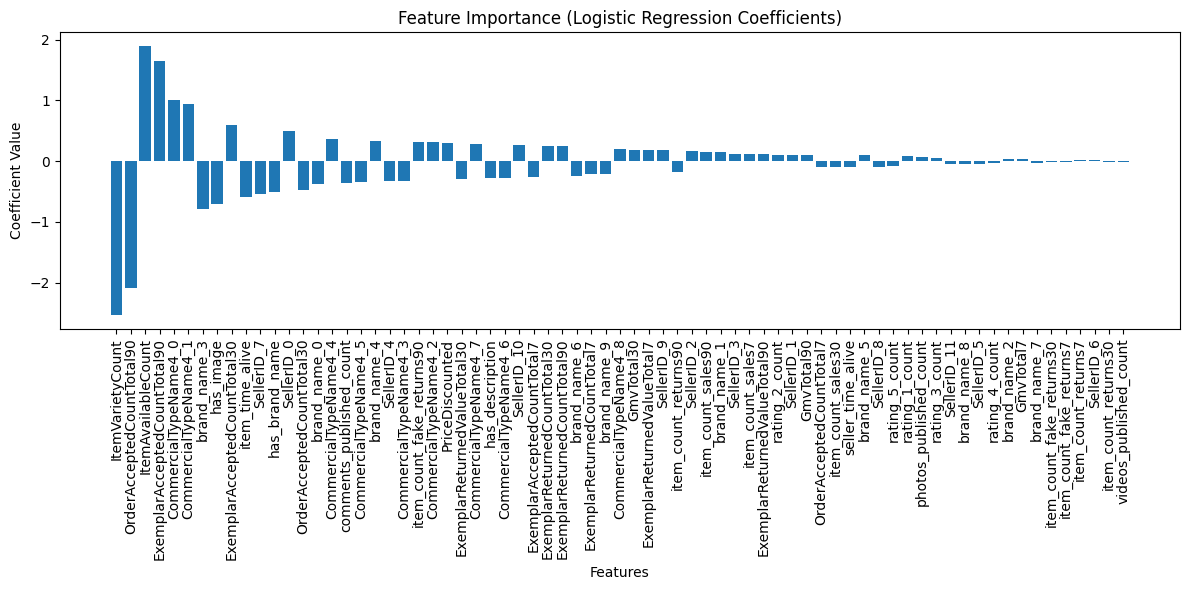

In [ ]:
# Посмотрим на коэффициенты модели

feature_names = train.drop(columns=["resolution"]).columns
coefs = model.coef_.ravel()

sorted_idx = np.argsort(np.abs(coefs))[::-1]
sorted_features = feature_names[sorted_idx]
sorted_coefs = coefs[sorted_idx]

print("Top 10 most informative features:")
for feat, coef in zip(sorted_features[:10], sorted_coefs[:10]):
    print(f"{feat}: {coef:.4f}")

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_features)), sorted_coefs)
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [ ]:
preds = model.predict(test)
submission = pd.DataFrame({"id": test_ids, "prediction": preds})
submission.head()
submission.to_csv("submission.csv", index=False)

f1: 0.4355

## SVC

In [ ]:
model = SVC(class_weight="balanced", max_iter=1000, verbose=2)
model.fit(train.drop(columns=["resolution"]), train["resolution"])

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1059.910409, rho = 0.219790
nSV = 1589, nBSV = 1000
Total nSV = 1589


/home/den/miniconda3/envs/ozon-e-cup/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,2


In [ ]:
preds = model.predict(test)
submission = pd.DataFrame({"id": test_ids, "prediction": preds})
submission.head()
submission.to_csv("submission.csv", index=False)

f1: 0.0418

## RF

In [ ]:
model = RandomForestClassifier(
    n_estimators=1000, class_weight="balanced", oob_score=f1_score, random_state=42, n_jobs=-1, verbose=1
)
model.fit(train.drop(columns=["resolution"]), train["resolution"])
model.oob_score_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.1min finished


0.7519355560528083

In [ ]:
preds = model.predict(test)
submission = pd.DataFrame({"id": test_ids, "prediction": preds})
submission.head()
submission.to_csv("submission.csv", index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.5s finished


f1: 0.5215

## GB

In [ ]:
model = GradientBoostingClassifier(
    learning_rate=0.2,
    n_estimators=1000,
    subsample=0.75,
    random_state=42,
    max_features="sqrt",
    n_iter_no_change=50,
    verbose=3,
)
model.fit(train.drop(columns=["resolution"]), train["resolution"])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4686           0.0194            4.09m
         2           0.4353           0.0260            4.37m
         3           0.4240           0.0181            5.00m
         4           0.4134           0.0049            4.98m
         5           0.4069           0.0109            4.99m
         6           0.3941           0.0125            5.09m
         7           0.3871           0.0034            4.82m
         8           0.3826           0.0048            4.79m
         9           0.3756           0.0051            4.73m
        10           0.3691           0.0028            4.84m
        11           0.3637           0.0088            4.85m
        12           0.3586          -0.0004            4.72m
        13           0.3601           0.0175            4.85m
        14           0.3522          -0.0158            4.92m
        15           0.3532           0.0173            4.87m
       

,loss,'log_loss'
,learning_rate,0.2
,n_estimators,1000
,subsample,0.75
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [ ]:
preds = model.predict(test)
submission = pd.DataFrame({"id": test_ids, "prediction": preds})
submission.head()
submission.to_csv("submission.csv", index=False)

f1: 0.5953

## HistGB

Похожий GB реализован в lightgbm.

In [ ]:
model = HistGradientBoostingClassifier(
    learning_rate=0.2,
    max_iter=1000,
    l2_regularization=0.5,
    max_features=0.75,
    max_bins=255,
    categorical_features=None,
    random_state=42,
    scoring=make_scorer(f1_score),
    n_iter_no_change=50,
    class_weight="balanced",
    verbose=3,
)
model.fit(train.drop(columns=["resolution"]), train["resolution"])

Binning 0.101 GB of training data: 0.965 s
Binning 0.011 GB of validation data: 0.050 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.78063, val score: 0.77011, in 0.103s
[2/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.80910, val score: 0.79421, in 0.099s
[3/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.82375, val score: 0.79886, in 0.100s
[4/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.83918, val score: 0.81272, in 0.108s
[5/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.83762, val score: 0.81221, in 0.120s
[6/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.84067, val score: 0.82420, in 0.116s
[7/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.84410, val score: 0.82385, in 0.113s
[8/1000] 1 tree, 31 leaves, max depth = 7, train score: 0.84707, val score: 0.83256, in 0.118s
[9/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.85227, val score: 0.83656, in 0.119s
[10/1000] 1 tree, 31 

,loss,'log_loss'
,learning_rate,0.2
,max_iter,1000
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.5
,max_features,0.75
,max_bins,255
,categorical_features,None
,monotonic_cst,None


In [ ]:
preds = model.predict(test)
submission = pd.DataFrame({"id": test_ids, "prediction": preds})
submission.head()
submission.to_csv("submission.csv", index=False)

f1: 0.595

# C кросс-валидацией

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Создаём сплиты
splits = create_stratified_splits(data=train)
len(splits)

3

In [ ]:
for i, (train_split, val_split) in enumerate(splits):
    print(f"Fold {i}: train size = {len(train_split)}, val size = {len(val_split)}")

Fold 0: train size = 157758, val size = 39440
Fold 1: train size = 157758, val size = 39440
Fold 2: train size = 157758, val size = 39440


In [ ]:
# Выкинем категориальные колонки
cols_to_drop = ["brand_name", "CommercialTypeName4"]
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

## HistGB

In [ ]:
estimator = HistGradientBoostingClassifier(
    learning_rate=0.1,
    categorical_features=None,
    early_stopping=True,
    scoring=make_scorer(f1_score),
    n_iter_no_change=25,
    verbose=0,
    class_weight="balanced",
    max_features=0.8,
)
param_grid = {
    "max_iter": [100, 500],
    "max_leaf_nodes": [31, 62],
    "max_depth": [25, None],
    "min_samples_leaf": [20, 50],
    "l2_regularization": [0.0, 1.0],
}

In [ ]:
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    cv=splits,
    scoring=make_scorer(f1_score),
    verbose=4,
    n_jobs=-1,
    refit=True,
)

In [ ]:
gscv.fit(train.drop(columns=["resolution"]), train["resolution"])

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 2/3] END l2_regularization=0.0, max_depth=25, max_iter=100, max_leaf_nodes=31, min_samples_leaf=20;, score=0.581 total time=  42.9s
[CV 1/3] END l2_regularization=0.0, max_depth=25, max_iter=100, max_leaf_nodes=31, min_samples_leaf=20;, score=0.586 total time=  44.5s
[CV 1/3] END l2_regularization=0.0, max_depth=25, max_iter=100, max_leaf_nodes=31, min_samples_leaf=50;, score=0.579 total time=  45.1s
[CV 3/3] END l2_regularization=0.0, max_depth=25, max_iter=100, max_leaf_nodes=31, min_samples_leaf=20;, score=0.577 total time=  47.4s
[CV 2/3] END l2_regularization=0.0, max_depth=25, max_iter=100, max_leaf_nodes=31, min_samples_leaf=50;, score=0.587 total time=  39.0s
[CV 3/3] END l2_regularization=0.0, max_depth=25, max_iter=100, max_leaf_nodes=31, min_samples_leaf=50;, score=0.575 total time=  38.4s
[CV 1/3] END l2_regularization=0.0, max_depth=25, max_iter=100, max_leaf_nodes=62, min_samples_leaf=20;, score=0.648 total 

,estimator,HistGradientB...od='predict'))
,param_grid,"{'l2_regularization': [0.0, 1.0], 'max_depth': [25, None], 'max_iter': [100, 500], 'max_leaf_nodes': [31, 62], ...}"
,scoring,make_scorer(f...hod='predict')
,n_jobs,-1
,refit,True
,cv,"[(array([ 0...ape=(157758,)), ...), (array([ 0...ape=(157758,)), ...), ...]"
,verbose,4
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [ ]:
model = gscv.best_estimator_

In [ ]:
preds = model.predict(test)
submission = pd.DataFrame({"id": test_ids, "prediction": preds})
submission.head()
submission.to_csv("submission.csv", index=False)

# optuna

In [ ]:
import optuna

In [ ]:
# Создаём сплиты
splits = create_stratified_splits(data=train)
len(splits)

3

In [ ]:
# Выкинем категориальные колонки
cols_to_drop = ["brand_name", "CommercialTypeName4"]
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

## LogisticRegression

In [ ]:
def objective(trial):
    scores = []
    for train_ids, val_ids in tqdm(splits, leave=False):
        X_train, X_val = train.iloc[train_ids].drop(columns=["resolution"]), train.iloc[val_ids].drop(
            columns=["resolution"]
        )
        y_train, y_val = train["resolution"].iloc[train_ids], train["resolution"].iloc[val_ids]

        model = LogisticRegression(
            penalty="l2",
            C=trial.suggest_float("C", 1e-4, 1e4, log=True),
            class_weight="balanced",
            random_state=42,
            max_iter=trial.suggest_int("max_iter", 100, 1000),
            n_jobs=-1,
        )

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = f1_score(y_val, preds, average="macro")

        scores.append(score)

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

In [ ]:
print("Study statistics: ")
print(" Number of finished trials:", len(study.trials))
print(" Number of pruned trials:", len(pruned_trials))
print(" Number of complete trials:", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print(" Value:", trial.value)
print(" Params:")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

Study statistics: 
 Number of finished trials: 50
 Number of pruned trials: 0
 Number of complete trials: 50
Best trial:
 Value: 0.5955110246144745
 Params:
  C: 0.8150946784608252
  max_iter: 322


In [ ]:
# Fit final model with best hyperparameters on whole train
final_model = LogisticRegression(
    penalty="l2", class_weight="balanced", random_state=42, n_jobs=-1, **study.best_params
)
final_model.fit(train.drop(columns=["resolution"]), train["resolution"])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.8150946784608252
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,322
,multi_class,'deprecated'


In [ ]:
submission = pd.DataFrame({"id": test_ids, "prediction": final_model.predict(test)})
submission.to_csv("submission.csv", index=False)

## GradientBoostingClassifier

In [ ]:
def objective(trial):
    scores = []
    for train_ids, val_ids in tqdm(splits, leave=False):
        X_train, X_val = train.iloc[train_ids].drop(columns=["resolution"]), train.iloc[val_ids].drop(
            columns=["resolution"]
        )
        y_train, y_val = train["resolution"].iloc[train_ids], train["resolution"].iloc[val_ids]

        model = GradientBoostingClassifier(
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            n_estimators=trial.suggest_int("n_estimators", 100, 1000),
            subsample=trial.suggest_float("subsample", 0.5, 1),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 50),
            min_weight_fraction_leaf=trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5),
            max_depth=trial.suggest_int("max_depth", 3, 25),
            min_impurity_decrease=trial.suggest_float("min_impurity_decrease", 0.0, 0.5),
            random_state=42,
            max_features=trial.suggest_float("max_features", 0.5, 1.0),
            validation_fraction=0.1,
            n_iter_no_change=25,
        )

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = f1_score(y_val, preds, average="macro")

        scores.append(score)

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)

[I 2025-08-27 17:17:29,079] A new study created in memory with name: no-name-5fa2cc51-7979-48ad-a00a-54be7db5ec25


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

In [ ]:
print("Study statistics: ")
print(" Number of finished trials:", len(study.trials))
print(" Number of pruned trials:", len(pruned_trials))
print(" Number of complete trials:", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print(" Value:", trial.value)
print(" Params:")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
# Fit final model with best hyperparameters on whole train
final_model = GradientBoostingClassifier(
    validation_fraction=0.1, n_iter_no_change=25, random_state=42, **study.best_params
)
final_model.fit(train.drop(columns=["resolution"]), train["resolution"])

In [ ]:
submission = pd.DataFrame({"id": test_ids, "prediction": final_model.predict(test)})
submission.to_csv("submission.csv", index=False)